<p style ="text-align:center">
    <img src="http://epecora.com.br/DataFiles/PPGOLD_logo.png" width="300" alt="PPGOLD Data Science: INTRO"  />
</p>

# Aula 04 de Data Science

# Regressão Não Linear
Tempo estimado: **60** minutos

## Objetivos

Após completar esta aula, você será capaz de:

* Criar um modelo de regressão não linear simples
* Criar um modelo de regressão não linear múltipla

## Obtendo os dados

In [23]:
import pandas as pd  
import numpy as np   
import math 
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import pearsonr # correlações de Pearson
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm # modelagem estatística
%matplotlib inline 

In [24]:
caminho = "" # o objeto ainda está vazio. 

caminho = "https://raw.githubusercontent.com/EduPekUfpr/PPGOLD7037/dev/Data/MeuAutoLimpo.csv" 

df = pd.read_csv(caminho) 

In [25]:
# Exibindo as cinco primeiras linhas do dataframe
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,164,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


<Figure size 1080x720 with 0 Axes>

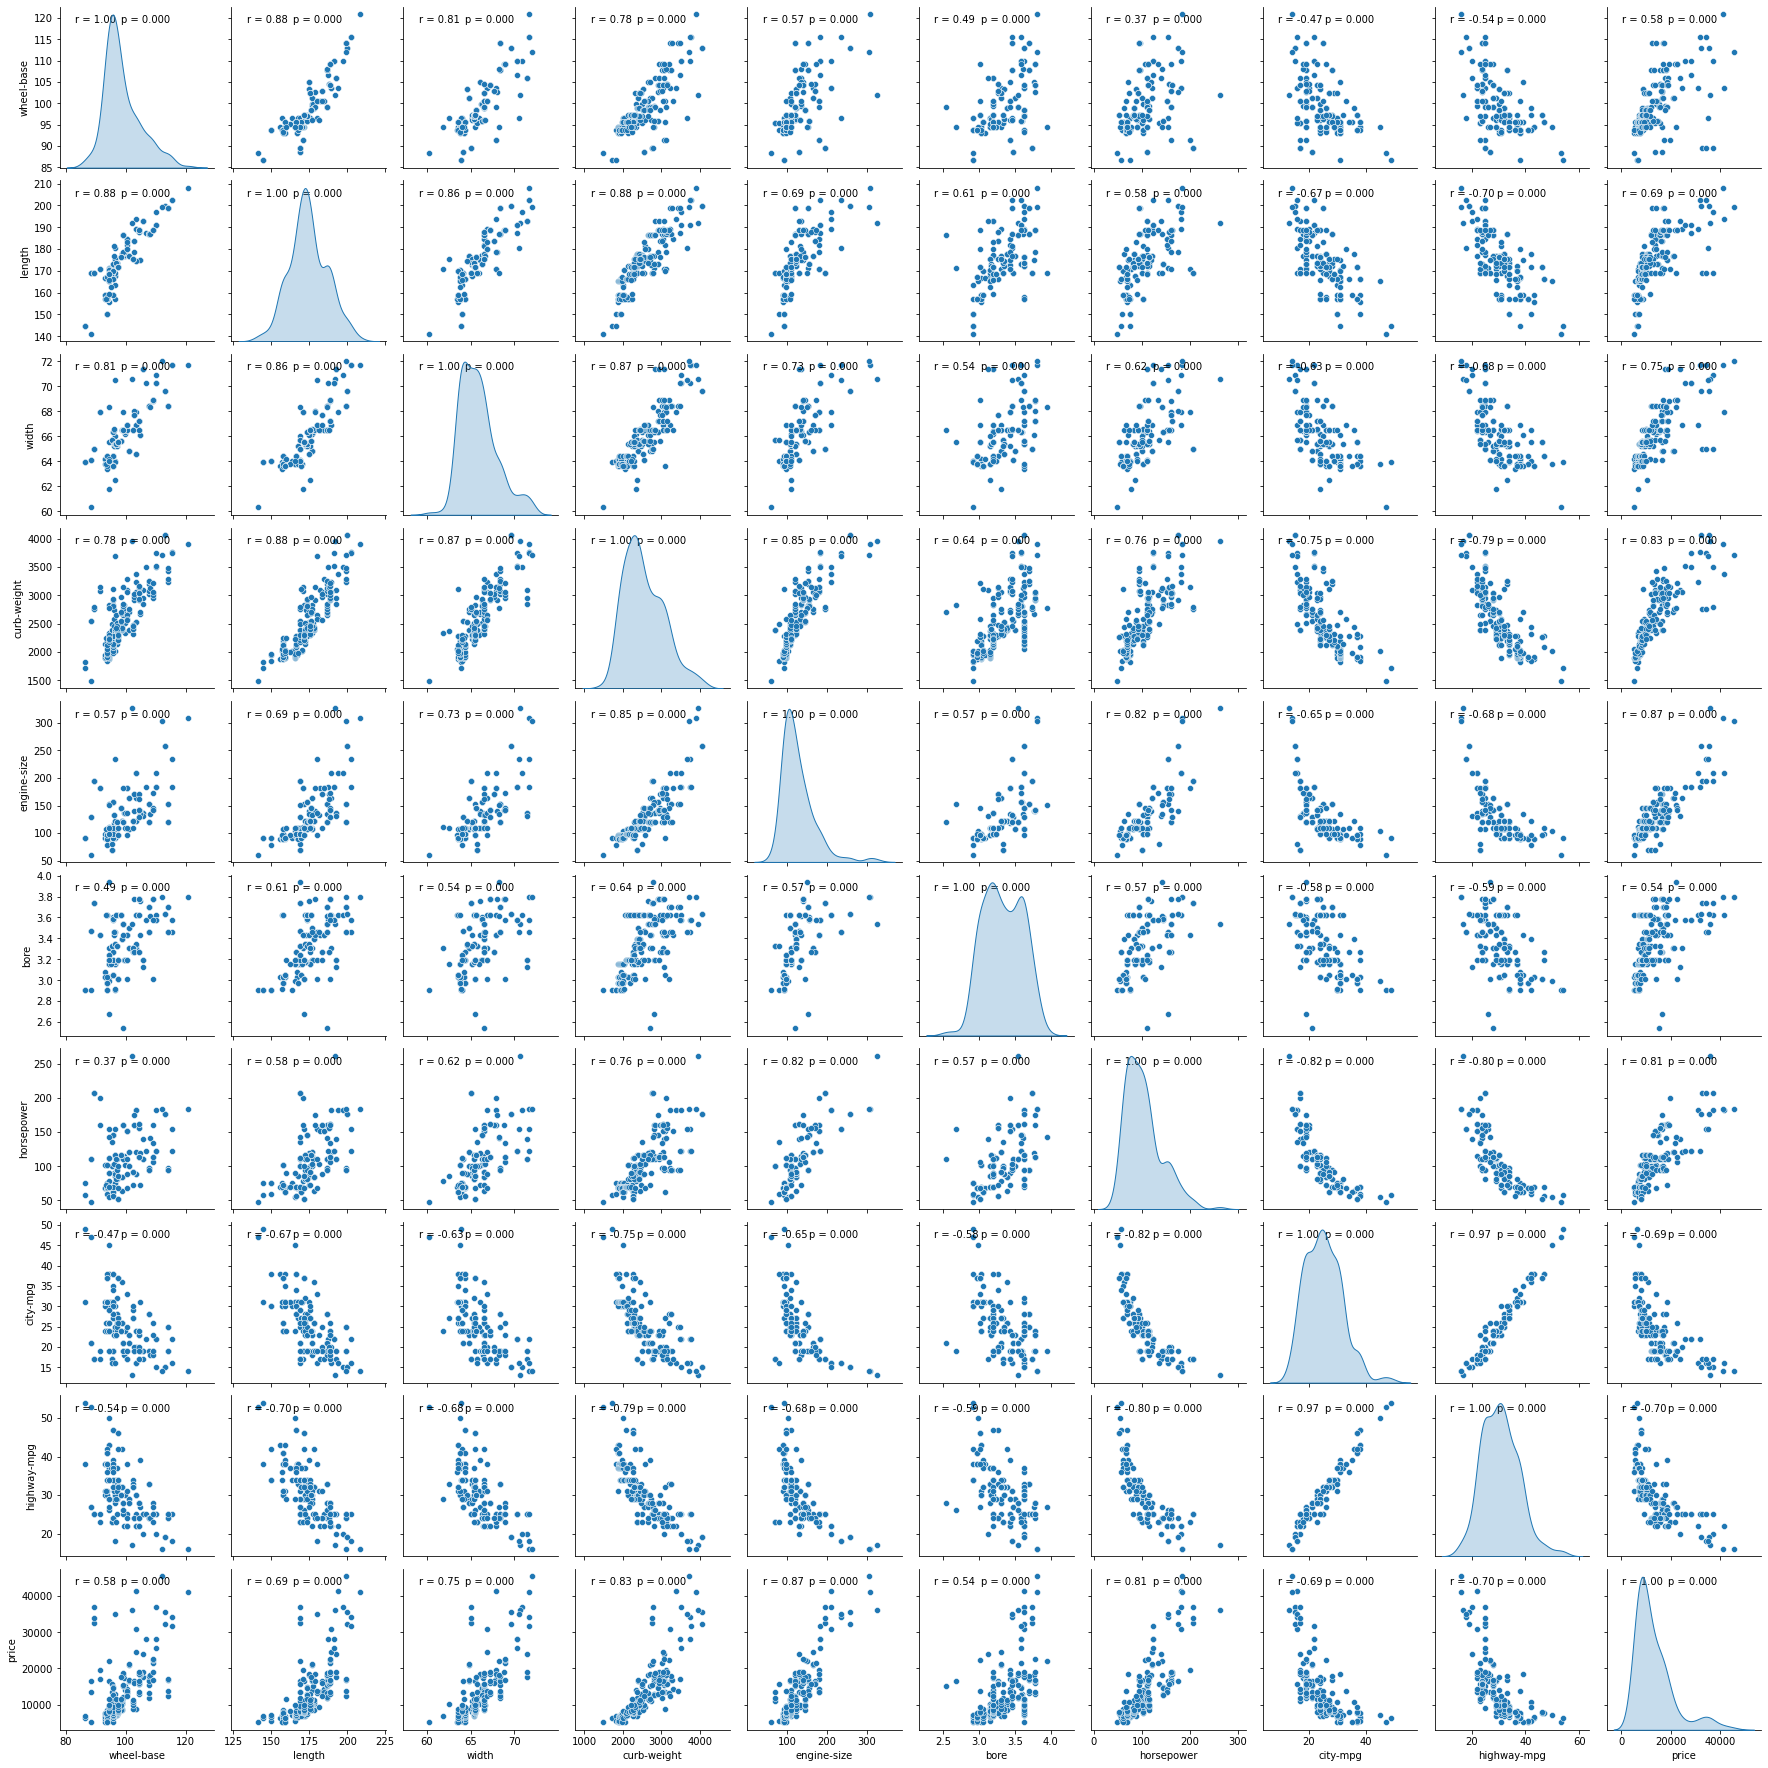

In [26]:
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

# Recriando dataframe com as melhores correlações e plotando os valores das correlações e as significâncias

df.drop(columns=['symboling','normalized-losses','height','stroke','compression-ratio','peak-rpm'] , axis="column" , inplace=True)

plt.figure(figsize=(15,10))
graph = sns.pairplot(df, diag_kind="kde")
graph.map(corrfunc)
plt.show()

## Modelo 1 - Regressão Não Linear Simples

### Box-Cox

$$
    X : Variável \ independente \\
    Y : Variável \ dependente \\
    \lambda : Parâmetro \ de \ Box-Cox \\
    Y_{bc} : Variável \ dependente \ de \ Box-Cox \ normalizada \ onde: \\
    Y_{bc}= \frac{Y^{\lambda}-1}{\lambda}
$$

**Função Não Linear**
$$
    Yhat_{bc}= a + \beta x
$$

* a : se refere ao intercepto da regressão linear, ou seja, o valor de Y quando X é 0.
* b : se refere a inclinação da reta, ou seja, o valor com o qual Y muda quando X aumenta em uma unidade.

### Implementação

* Como poderia `highway-mpg` nos ajudar a prever o preço do carro?
* Para este exemplo, queremos ver como a `highway-mpg` pode nos ajudar a prever o preço do carro.
* Usando a regressão linear simples, criaremos uma função linear com `highway-mpg` como a variável preditor e o `price` como a variável de resposta.

In [27]:
# Criando um objeto para regressão linear e uma para não linear
lm = LinearRegression()
lm_bc = LinearRegression()

In [28]:
# Verificando a estatística descritiva
df_Naolinear = df[['price','highway-mpg']].copy(deep=True)

# renomeando porque o modelo não gosta de traços
df_Naolinear = df_Naolinear.rename(columns={'highway-mpg': 'highway_mpg'})
df_Naolinear.describe()

,price,highway_mpg
count,201.000000,201.000000
mean,13207.129353,30.686567
std,7947.066342,6.815150
min,5118.000000,16.000000
25%,7775.000000,25.000000
50%,10295.000000,30.000000
75%,16500.000000,34.000000
max,45400.000000,54.000000


<AxesSubplot: xlabel='highway_mpg', ylabel='price'>

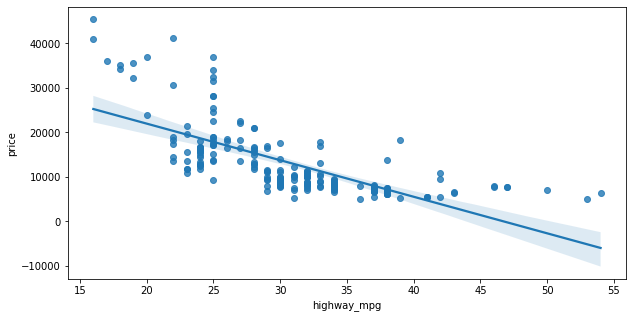

In [29]:
#Avaliando gráfico de uma regressão linear com 95% de intervalo de confiança
plt.figure(figsize=(10,5))
sns.regplot(df_Naolinear,x='highway_mpg',y='price')

In [30]:
#Para o cálculo do lambda de Box-Cox
from scipy.stats import boxcox

# x é uma variável que traz os valores transformados (Y_bc)
# 'lmbda' é o lambda de Box-Cox
x, lmbda = boxcox(df_Naolinear['price'])
print('Lambda=',lmbda)
#Inserindo a variável transformada ('bc_preco') no dataset
#para a estimação de um novo modelo
df_Naolinear['price_bc'] = x

Lambda= -0.6295461760965264


In [31]:
#Avaliando o preço normalizado por boxcox
df_Naolinear[['price_bc','price']].head() 

,price_bc,price
0,1.584457,13495.0
1,1.584931,16500.0
2,1.584931,16500.0
3,1.584539,13950.0
4,1.585053,17450.0


<AxesSubplot: xlabel='highway_mpg', ylabel='price_bc'>

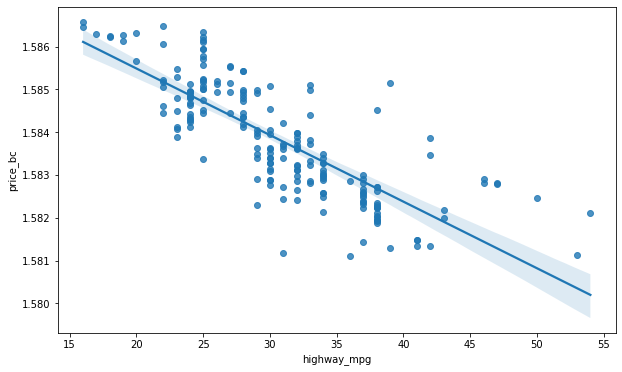

In [32]:
# Aqui o SciKit Learn precisa da amostras e da dimensão, 
# Por isso precisamos passar uma matriz ou dataFrame
X = df_Naolinear[['highway_mpg']]   

# Criando variáveis Y e a variável Y_bc
Y = df_Naolinear['price']
Y_bc = df_Naolinear['price_bc']

# Avaliando a nova dispersão dos pontos
plt.figure(figsize=(10,6))
sns.regplot(df_Naolinear,x='highway_mpg',y='price_bc')

* Aplica o modelo Linear usando somente `highway-mpg` como variável Independente


In [33]:
# Criando a regressão linear
lm.fit(X,Y)

# Criando a regressão não linear
lm_bc.fit(X,Y_bc)

LinearRegression()

* Calcular os valores previstos:


In [34]:
# Valores da predição com box cox
Yhat_bc = lm_bc.predict(X)

# Passando o valor predito de box cox
df_Naolinear.loc[:,'Yhat_bc'] = Yhat_bc

Yhat_bc_transf = (df_Naolinear.loc[:,'Yhat_bc']  * lmbda + 1) ** (1 / lmbda)

# Transformando a variável novamento
df_Naolinear.loc[:,'Yhat_bc_transf'] = Yhat_bc_transf

# Valores da predição linear
Yhat = lm.predict(X)

# Passando para o dataframe
df_Naolinear.loc[:,'Yhat']  = Yhat

# Avaliando
df_Naolinear.head(10)

,price,highway_mpg,price_bc,Yhat_bc,Yhat_bc_transf,Yhat
0,13495.0,27,1.584457,1.584400,13192.556181,16236.504643
1,16500.0,27,1.584931,1.584400,13192.556181,16236.504643
2,16500.0,26,1.584931,1.584555,14040.762805,17058.238022
3,13950.0,30,1.584539,1.583933,11091.339054,13771.304508
4,17450.0,22,1.585053,1.585178,18522.294088,20345.171535
5,15250.0,25,1.584753,1.584711,14981.577209,17879.971400
6,17710.0,25,1.585084,1.584711,14981.577209,17879.971400
7,18920.0,25,1.585221,1.584711,14981.577209,17879.971400
8,23875.0,20,1.585661,1.585489,21714.741468,21988.638292
9,16430.0,29,1.584922,1.584088,11727.245485,14593.037887


* Avaliando a estatistica descritiva

In [35]:
df_Naolinear.describe()

,price,highway_mpg,price_bc,Yhat_bc,Yhat_bc_transf,Yhat
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,13207.129353,30.686567,1.583826,1.583826,11924.620378,13207.129353
std,7947.066342,6.815150,0.001325,0.001061,4662.147315,5600.236181
min,5118.000000,16.000000,1.581102,1.580197,4255.516266,-5950.296571
25%,7775.000000,25.000000,1.582802,1.583310,9033.014003,10484.370995
50%,10295.000000,30.000000,1.583716,1.583933,11091.339054,13771.304508
75%,16500.000000,34.000000,1.584931,1.584711,14981.577209,17879.971400
max,45400.000000,54.000000,1.586587,1.586112,31613.734342,25275.571805


**Qual o erro da precisão (R2)?**

* R2 = 1
    * Todos os pontos observados estão sobre a reta estimada. 
    * Neste caso, as variações de Y são 100% explicadas pelas variações de X, através da função especificada, não havendo desvios em torno da reta estimada.
* R2 = 0
    * As variáveis de Y são puramente aleatórias e a inclusão da variável X no modelo não trará informação alguma sobre as variações de Y.


In [37]:
R2 = lm.score(X, Y)
R2_bc = lm_bc.score(X, Y_bc)
print("SCORE: ",R2,"SCORE BC: ",R2_bc)

SCORE:  0.4965911884339176 SCORE BC:  0.6411889816399028


### Analisando a Predição

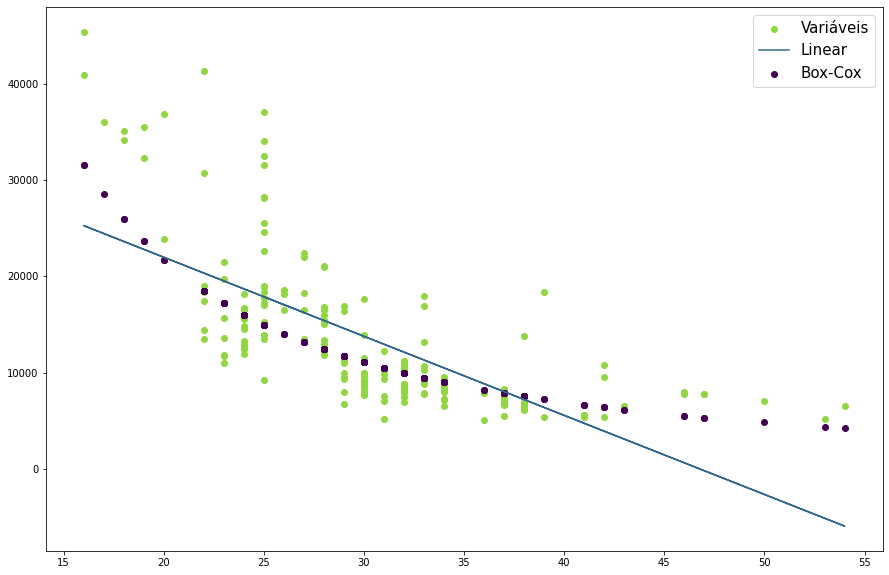

In [45]:
plt.figure(figsize=(15, 10))
plt.scatter(X, Y,color='#90d743')
plt.plot(X, Yhat,color='#31688e')
plt.scatter(X, Yhat_bc_transf,color='#440154')
plt.legend(labels=['Variáveis','Linear','Box-Cox'], fontsize = 15, bbox_to_anchor=(1, 1))
plt.show()

* Vamos usar o recurso gráfico para comparar o preço previsto vs o real.

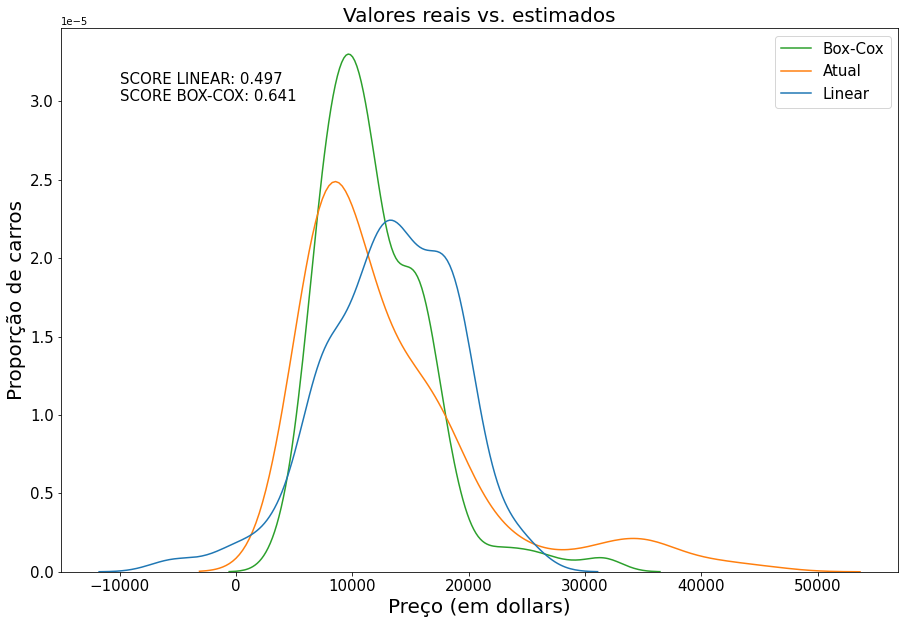

In [56]:
%matplotlib inline 
plt.figure(figsize=(15, 10))

sns.kdeplot(data = df_Naolinear[['Yhat','price','Yhat_bc_transf']]) # KDE - kernel density estimate

plt.title('Valores reais vs. estimados', size = 20)
plt.xlabel('Preço (em dollars)', size = 20)
plt.ylabel('Proporção de carros', size = 20)
plt.yticks(size = 15)
plt.xticks(size = 15) 
plt.legend(labels=['Box-Cox','Atual','Linear'], fontsize = 15, bbox_to_anchor=(1, 1))

tt = "SCORE LINEAR: %.3f \nSCORE BOX-COX: %.3f" % (R2, R2_bc)

plt.text(-10000, 0.00003, tt, size = 15)

plt.show()
plt.close()

### Cálculo dos erros:

* **Erro Linear**

Text(0.5, 0, 'Resíduo (em dollars)')

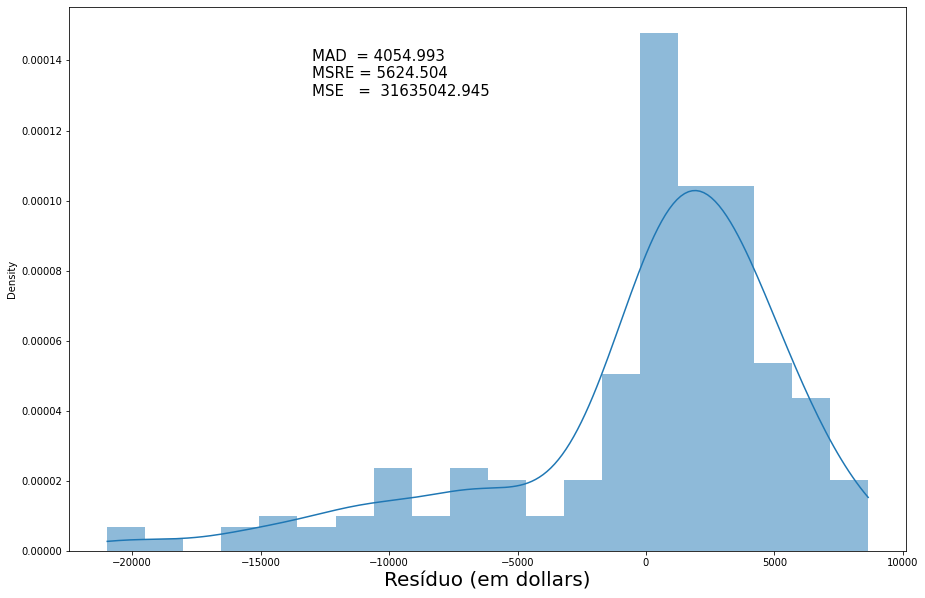

In [58]:
# Erro
df_Naolinear.loc[:,'Deviation'] = df_Naolinear['Yhat']-df_Naolinear['price']

# Erro absoluto
df_Naolinear.loc[:,'AbsDeviation'] = abs(df_Naolinear['Yhat']-df_Naolinear['price'])

# Quadrado do erro absolulto
df_Naolinear.loc[:,'SquaredError'] = (df_Naolinear['price']-df_Naolinear['Yhat'])**2

# Mean Absolute Desviation - Erro absoluto médio
MAD = df_Naolinear['AbsDeviation'].mean()

# Mean Squared Error - Erro quadrado médio
MSE = df_Naolinear['SquaredError'].mean()

# Mean Squared Root Error = Raiz do erro quadrado médio
MSRE = math.sqrt(MSE)

%matplotlib inline 
plt.figure(figsize=(15, 10))

tt = "MAD  = %.3f \nMSRE = %.3f \nMSE   =  %.3f" % (MAD, MSRE, MSE)

sns.histplot(x=df_Naolinear['Deviation'], kde=True, stat="density", linewidth=0)
plt.text(-13000, 0.00013, tt, size=15, color = "black")
plt.xlabel('Resíduo (em dollars)', size = 20)

* **Erro Não Linear**

Text(0.5, 0, 'Resíduo (em dollars)')

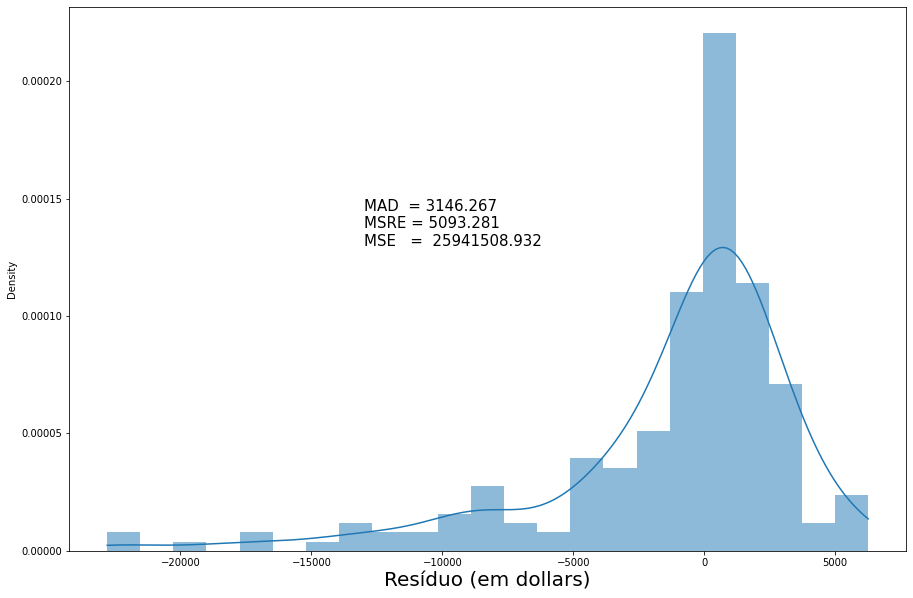

In [59]:
# Erro
df_Naolinear.loc[:,'Deviation_bc'] = df_Naolinear['Yhat_bc_transf']-df_Naolinear['price']

# Erro absoluto
df_Naolinear.loc[:,'AbsDeviation_bc'] = abs(df_Naolinear['Yhat_bc_transf']-df_Naolinear['price'])

# Quadrado do erro absolulto
df_Naolinear.loc[:,'SquaredError_bc'] = (df_Naolinear['price']-df_Naolinear['Yhat_bc_transf'])**2

# Mean Absolute Desviation - Erro absoluto médio
MAD = df_Naolinear['AbsDeviation_bc'].mean()

# Mean Squared Error - Erro quadrado médio
MSE = df_Naolinear['SquaredError_bc'].mean()

# Mean Squared Root Error = Raiz do erro quadrado médio
MSRE = math.sqrt(MSE)

%matplotlib inline 
plt.figure(figsize=(15, 10))

tt = "MAD  = %.3f \nMSRE = %.3f \nMSE   =  %.3f" % (MAD, MSRE, MSE)

sns.histplot(x=df_Naolinear['Deviation_bc'], kde=True, stat="density", linewidth=0)
plt.text(-13000, 0.00013, tt, size=15, color = "black")
plt.xlabel('Resíduo (em dollars)', size = 20)

* Calculando os erros

### Teste de Shapiro-Francia para verificar se os erros tem aderência a normalidade
* Se o p-valor for menor do que 0.05 então a distribuição não está aderente a normalidade
* Se o p-valor for maior do que 0.05 então a distribuição ESTÁ aderente a normalidade.

In [627]:
# importar a biblioteca Shapiro-Francia para verificar se os erros tem aderência a normalidade
# ! pip install statstests
# ! pip install statsmodels

In [62]:
import statsmodels.api as sm # biblioteca de modelagem estatística
from statstests.tests import shapiro_francia

In [64]:
# teste de shapiro francia para avaliar a aderencia dos resíduos a normalidade
shapiro_test = shapiro_francia(df_Naolinear.loc[:,'Deviation_bc'])
print("Se o valor for menor que 0.05 será rejeitado, Valor: {:.6f}".format(shapiro_test['p-value']))

method  :  Shapiro-Francia normality test
statistics W  :  0.8114069266479044
statistics z  :  7.091732151583248
p-value  :  6.622183418849652e-13
Se o valor for menor que 0.05 será rejeitado, Valor: 0.000000


* Como apenas uma variável não foi capaz de aderir a o resíduo a normalidade, então utilizaremos todas as variáveis da tabela no processo stepwise para selecionar as melhores variáveis
* Iniciando com a preparação das demais variáveis tanto qualitativas quanto categóricas

## Modelo 2 - Regressão Não Linear Múltipla

### Box-Cox

$$
    X : Variável \ independente \\
    Y : Variável \ dependente \\
    \lambda : Parâmetro \ de \ Box-Cox \\
    Y_{bc} : Variável \ dependente \ de \ Box-Cox \ normalizada \ onde: \\
    Y_{bc}= \frac{Y^{\lambda}-1}{\lambda}
$$

**Função Não Linear**
$$
    Yhat_{bc}= a + \beta x
$$

* a : se refere ao intercepto da regressão linear, ou seja, o valor de Y quando X é 0.
* b : se refere a inclinação da reta, ou seja, o valor com o qual Y muda quando X aumenta em uma unidade.

### Pre-Processamento

### Dummies

### Stepwise

### Anova

### Shapiro